### Cartoon Portrait with GAN

##### Introduction and Preprocessing

本节参考 [斗大的熊猫](http://blog.topspeedsnail.com/archives/10977) ，GANs-生成对抗网络 (生成明星脸)

代码参考 

- [GAN initial paper](https://arxiv.org/abs/1406.2661)
- [GAN学习指南：从原理入门到制作生成Demo](https://zhuanlan.zhihu.com/p/24767059)
- [Energy Based Generative Adversarial Networks (EBGAN)](https://arxiv.org/pdf/1609.03126v2.pdf)

使用的数据集：[Cartoon Face](https://zhuanlan.zhihu.com/p/24767059)

数据集中有 5 万多张卡通头像图片

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import numpy as np
import PIL.Image
import scipy.misc as misc
from IPython.display import Image, display

In [3]:
tf.__version__

'0.9.0'

##### Part I. 探索数据集

In [4]:
datadir = 'data/faces'
train_images = []

for f in os.listdir(datadir):
    if f.endswith('.jpg'):
        train_images.append(os.path.join(datadir, f))

random.shuffle(train_images)
print len(train_images)
print train_images[:5]

51223
['data/faces/d1352d1c2bf2bf2d345d0578dbe97fdf-0.jpg', 'data/faces/2bd8ccc94573717ee9e3a0325c23008f-1.jpg', 'data/faces/be7ec1a2bd825acf5b29eead6d28c97e-0.jpg', 'data/faces/17730fea46bb8c5f620aa6564135ecb1-0.jpg', 'data/faces/7bf425b86d6977a5e25d54208be131f4-0.jpg']


看到共计 51223 个头像图片

下面参考 11_DeepDream.ipynb，实现几个图像处理函数

In [6]:
# 加载图片，返回其 floating-points
def load_image(filename):
    image = PIL.Image.open(filename)
    return np.float32(image)

# 给定一个 numpy array 且取值为 0~255 的输入数组，保存为 jpeg 图片文件；类似于上一个函数的反函数
def save_image(image, filename):
    # 确保在 0~255 之间
    image = np.clip(image, 0.0, 255.0)
    # 转为 byte
    image = image.astype(np.uint8)
    # 写入 jpeg 格式的文件
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')
        
# 给定一个像素在 0~255 之间的图片，原作者使用 PIL 绘制更好看的图片，然而我这里调用 PIL 的函数却显示不出来图片
# 只要选择了使用 matplotlib 绘制低分辨率图片
def plot_image(image, pltshow=True):
    if pltshow:
        # 转为 0~1
        image = np.clip(image/255.0, 0.0, 1.0)
        # 使用 matplotlib 绘制
        plt.imshow(image, interpolation='lanczos')
        plt.show()
    else:
        image = np.clip(image, 0.0, 255.0)   # 确保 0~255
        # 转为 bytes.
        image = image.astype(np.uint8)
        # PIL 绘制
        display(PIL.Image.fromarray(image))

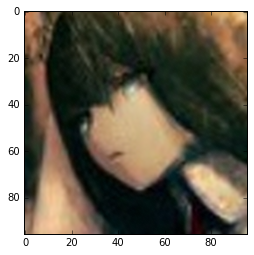

(96, 96, 3)


In [16]:
plot_image(load_image('data/faces/d1352d1c2bf2bf2d345d0578dbe97fdf-0.jpg'))
image = load_image('data/faces/d1352d1c2bf2bf2d345d0578dbe97fdf-0.jpg')
print image.shape

看到图片的 size 为 96 96 3

In [17]:
batch_size = 64
num_batch = len(train_images) // batch_size
print "num_batch: {}".format(num_batch)

IMAGE_SIZE = 96
IMAGE_CHANNEL = 3

num_batch: 800


In [18]:
def get_next_batch(idx):
    batch = []
    images = train_images[idx * batch_size: (idx + 1) * batch_size]
    for img in images:
        # 96 * 96 * 3
        image = load_image(img)
        # 转为 -1 ~ 1 之间的浮点数
        image = image / 127.5 - 1  
        batch.append(image)
    return batch


##### Part II. Layer definations

In [19]:
# 首先定义一些基础数据

# 噪声
z_dim = 100
noise = tf.placeholder(tf.float32, [None, z_dim], name='noise')

# X
X = tf.placeholder(tf.float32, [batch_size, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL], name='X')

# 是否在训练阶段
train_phase = tf.placeholder(tf.bool)

In [20]:
# http://stackoverflow.com/a/34634291/2267819
def batch_norm(x, beta, gamma, phase_train, scope='bn', decay=0.9, eps=1e-5):
    """
    Batch normalization on convolutional maps.
    Args:
        x:           Tensor, 4D BHWD input maps
        beta:        tf.get_variable(name='beta', shape=[n_out], initializer=tf.constant_initializer(0.0), trainable=True)
        gamma:       tf.get_variable(name='gamma', shape=[n_out], initializer=tf.random_normal_initializer(1.0, stddev), trainable=True)
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope(scope):
        batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=decay)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train, mean_var_with_update, lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, eps)
    return normed


In [21]:
# Genarator，由 noise 生成图像
generator_variables_dict = {
    # 普通 hidden 层
    "W_1": tf.Variable(tf.truncated_normal([z_dim, 2 * IMAGE_SIZE * IMAGE_SIZE], stddev=0.02), name='Generator/W_1'),
    "b_1": tf.Variable(tf.constant(0.0, shape=[2 * IMAGE_SIZE * IMAGE_SIZE]), name='Generator/b_1'),
    'beta_1': tf.Variable(tf.constant(0.0, shape=[512]), name='Generator/beta_1'),
    'gamma_1': tf.Variable(tf.random_normal(shape=[512], mean=1.0, stddev=0.02), name='Generator/gamma_1'),

    # 反卷积层，filter 5 * 5，output_channel 256 ，input_channel 为上一层输出的 512 
    "W_2": tf.Variable(tf.truncated_normal([5, 5, 256, 512], stddev=0.02), name='Generator/W_2'),
    "b_2": tf.Variable(tf.constant(0.0, shape=[256]), name='Generator/b_2'),
    'beta_2': tf.Variable(tf.constant(0.0, shape=[256]), name='Generator/beta_2'),
    'gamma_2': tf.Variable(tf.random_normal(shape=[256], mean=1.0, stddev=0.02), name='Generator/gamma_2'),

    # 反卷积层，output_channel 减少一倍，后面代码中看到，输出尺寸增大一倍
    "W_3": tf.Variable(tf.truncated_normal([5, 5, 128, 256], stddev=0.02), name='Generator/W_3'),
    "b_3": tf.Variable(tf.constant(0.0, shape=[128]), name='Generator/b_3'),
    'beta_3': tf.Variable(tf.constant(0.0, shape=[128]), name='Generator/beta_3'),
    'gamma_3': tf.Variable(tf.random_normal(shape=[128], mean=1.0, stddev=0.02), name='Generator/gamma_3'),

    # 反卷积层，output_channel 减少一倍，后面代码中看到，输出尺寸增大一倍
    "W_4": tf.Variable(tf.truncated_normal([5, 5, 64, 128], stddev=0.02), name='Generator/W_4'),
    "b_4": tf.Variable(tf.constant(0.0, shape=[64]), name='Generator/b_4'),
    'beta_4': tf.Variable(tf.constant(0.0, shape=[64]), name='Generator/beta_4'),
    'gamma_4': tf.Variable(tf.random_normal(shape=[64], mean=1.0, stddev=0.02), name='Generator/gamma_4'),

    # 反卷积层，output_channel 减少一倍，输出尺寸增大一倍，不再做 batch_norm
    "W_5": tf.Variable(tf.truncated_normal([5, 5, IMAGE_CHANNEL, 64], stddev=0.02), name='Generator/W_5'),
    "b_5": tf.Variable(tf.constant(0.0, shape=[IMAGE_CHANNEL]), name='Generator/b_5')
}

# Generator
def generator(noise):
    with tf.variable_scope("Generator"):
        out_1 = tf.matmul(noise, generator_variables_dict["W_1"]) + generator_variables_dict['b_1']
        # 这里做了个 reshape， 16 * 16 * 2 = 512，故此这里 beta_1 & gamma_1 都是 512；
        out_1 = tf.reshape(out_1, [-1, IMAGE_SIZE//16, IMAGE_SIZE//16, 512])
        out_1 = batch_norm(out_1, generator_variables_dict["beta_1"], generator_variables_dict["gamma_1"], train_phase, scope='bn_1')
        # out_1 为 batch_size * (96/16) * (96/16) * 512 维度，即 output_channel 为 512
        out_1 = tf.nn.relu(out_1, name='relu_1')

        # 定义了反卷积的输出尺寸 IMAGE_SIZE//8 * IMAGE_SIZE//8 即  12 x 12
        out_2 = tf.nn.conv2d_transpose(out_1, generator_variables_dict['W_2'],  output_shape=tf.pack([tf.shape(out_1)[0], IMAGE_SIZE//8, IMAGE_SIZE//8, 256]), strides=[1, 2, 2, 1], padding='SAME')
        out_2 = tf.nn.bias_add(out_2, generator_variables_dict['b_2'])
        out_2 = batch_norm(out_2, generator_variables_dict["beta_2"], generator_variables_dict["gamma_2"], train_phase, scope='bn_2')
        out_2 = tf.nn.relu(out_2, name='relu_2')

        # 反卷积层，output_channel 减少一倍，输出尺寸增大一倍
        out_3 = tf.nn.conv2d_transpose(out_2, generator_variables_dict['W_3'],  output_shape=tf.pack([tf.shape(out_2)[0], IMAGE_SIZE//4, IMAGE_SIZE//4, 128]), strides=[1, 2, 2, 1], padding='SAME')
        out_3 = tf.nn.bias_add(out_3, generator_variables_dict['b_3'])
        out_3 = batch_norm(out_3, generator_variables_dict["beta_3"], generator_variables_dict["gamma_3"], train_phase, scope='bn_3')
        out_3 = tf.nn.relu(out_3, name='relu_3')

        # 反卷积层，output_channel 减少一倍，输出尺寸增大一倍
        out_4 = tf.nn.conv2d_transpose(out_3, generator_variables_dict['W_4'],  output_shape=tf.pack([tf.shape(out_3)[0], IMAGE_SIZE//2, IMAGE_SIZE//2, 64]), strides=[1, 2, 2, 1], padding='SAME')
        out_4 = tf.nn.bias_add(out_4, generator_variables_dict['b_4'])
        out_4 = batch_norm(out_4, generator_variables_dict["beta_4"], generator_variables_dict["gamma_4"], train_phase, scope='bn_4')
        out_4 = tf.nn.relu(out_4, name='relu_4')

        # 反卷积层，output_channel 减少一倍，输出尺寸增大一倍，不再做 batch_norm
        out_5 = tf.nn.conv2d_transpose(out_4, generator_variables_dict['W_5'],  output_shape=tf.pack([tf.shape(out_4)[0], IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL]), strides=[1, 2, 2, 1], padding='SAME')
        out_5 = tf.nn.bias_add(out_5, generator_variables_dict['b_5'])
        out_5 = tf.nn.tanh(out_5, name='tanh_5')

        return out_5

In [24]:
# discriminator，judge 真假
discriminator_variables_dict = {
    # 卷积层
    "W_1": tf.Variable(tf.truncated_normal([4, 4, IMAGE_CHANNEL, 32], stddev=0.002), name='Discriminator/W_1'),
    "b_1": tf.Variable(tf.constant(0.0, shape=[32]), name='Discriminator/b_1'),
    'beta_1': tf.Variable(tf.constant(0.0, shape=[32]), name='Discriminator/beta_1'),
    'gamma_1': tf.Variable(tf.random_normal(shape=[32], mean=1.0, stddev=0.02), name='Discriminator/gamma_1'),

    # 卷积层
    "W_2": tf.Variable(tf.truncated_normal([4, 4, 32, 64], stddev=0.002), name='Discriminator/W_2'),
    "b_2": tf.Variable(tf.constant(0.0, shape=[64]), name='Discriminator/b_2'),
    'beta_2': tf.Variable(tf.constant(0.0, shape=[64]), name='Discriminator/beta_2'),
    'gamma_2': tf.Variable(tf.random_normal(shape=[64], mean=1.0, stddev=0.02), name='Discriminator/gamma_2'),

    # 卷积层
    "W_3": tf.Variable(tf.truncated_normal([4, 4, 64, 128], stddev=0.002), name='Discriminator/W_3'),
    "b_3": tf.Variable(tf.constant(0.0, shape=[128]), name='Discriminator/b_3'),
    'beta_3': tf.Variable(tf.constant(0.0, shape=[128]), name='Discriminator/beta_3'),
    'gamma_3': tf.Variable(tf.random_normal(shape=[128], mean=1.0, stddev=0.02), name='Discriminator/gamma_3'),

    # 反卷积层
    "W_4": tf.Variable(tf.truncated_normal([4, 4, 64, 128], stddev=0.002), name='Discriminator/W_4'),
    "b_4": tf.Variable(tf.constant(0.0, shape=[64]), name='Discriminator/b_4'),
    'beta_4': tf.Variable(tf.constant(0.0, shape=[64]), name='Discriminator/beta_4'),
    'gamma_4': tf.Variable(tf.random_normal(shape=[64], mean=1.0, stddev=0.02), name='Discriminator/gamma_4'),

    # 反卷积层
    "W_5": tf.Variable(tf.truncated_normal([4, 4, 32, 64], stddev=0.002), name='Discriminator/W_5'),
    "b_5": tf.Variable(tf.constant(0.0, shape=[32]), name='Discriminator/b_5'),
    'beta_5': tf.Variable(tf.constant(0.0, shape=[32]), name='Discriminator/beta_5'),
    'gamma_5': tf.Variable(tf.random_normal(shape=[32], mean=1.0, stddev=0.02), name='Discriminator/gamma_5'),

    # 反卷积层
    "W_6": tf.Variable(tf.truncated_normal([4, 4, 3, 32], stddev=0.002), name='Discriminator/W_6'),
    "b_6": tf.Variable(tf.constant(0.0, shape=[3]), name='Discriminator/b_6')
}

# Energy based Discriminator 其实是个自编码器
def discriminator(input_images):
    with tf.variable_scope("Discriminator"):
        # Encoder
        out_1 = tf.nn.conv2d(input_images, discriminator_variables_dict['W_1'], strides=[1, 2, 2, 1], padding='SAME')
        out_1 = tf.nn.bias_add(out_1, discriminator_variables_dict['b_1'])
        out_1 = batch_norm(out_1, discriminator_variables_dict['beta_1'], discriminator_variables_dict['gamma_1'], train_phase, scope='bn_1')
        out_1 = tf.maximum(0.2 * out_1, out_1, 'leaky_relu_1')

        out_2 = tf.nn.conv2d(out_1, discriminator_variables_dict['W_2'], strides=[1, 2, 2, 1], padding='SAME')
        out_2 = tf.nn.bias_add(out_2, discriminator_variables_dict['b_2'])
        out_2 = batch_norm(out_2, discriminator_variables_dict['beta_2'], discriminator_variables_dict['gamma_2'], train_phase, scope='bn_2')
        out_2 = tf.maximum(0.2 * out_2, out_2, 'leaky_relu_2')

        out_3 = tf.nn.conv2d(out_2, discriminator_variables_dict['W_3'], strides=[1, 2, 2, 1], padding='SAME')
        out_3 = tf.nn.bias_add(out_3, discriminator_variables_dict['b_3'])
        out_3 = batch_norm(out_3, discriminator_variables_dict['beta_3'], discriminator_variables_dict['gamma_3'], train_phase, scope='bn_3')
        out_3 = tf.maximum(0.2 * out_3, out_3, 'leaky_relu_3')
        encode = tf.reshape(out_3, [-1, 2*IMAGE_SIZE*IMAGE_SIZE])

        # Decoder
        out_3 = tf.reshape(encode, [-1, IMAGE_SIZE//8, IMAGE_SIZE//8, 128])
        
        out_4 = tf.nn.conv2d_transpose(out_3, discriminator_variables_dict['W_4'],  output_shape=tf.pack([tf.shape(out_3)[0], IMAGE_SIZE//4, IMAGE_SIZE//4, 64]), strides=[1, 2, 2, 1], padding='SAME')
        out_4 = tf.nn.bias_add(out_4, discriminator_variables_dict['b_4'])
        out_4 = batch_norm(out_4, discriminator_variables_dict['beta_4'], discriminator_variables_dict['gamma_4'], train_phase, scope='bn_4')
        out_4 = tf.maximum(0.2 * out_4, out_4, 'leaky_relu_4')

        out_5 = tf.nn.conv2d_transpose(out_4, discriminator_variables_dict['W_5'],  output_shape=tf.pack([tf.shape(out_4)[0], IMAGE_SIZE//2, IMAGE_SIZE//2, 32]), strides=[1, 2, 2, 1], padding='SAME')
        out_5 = tf.nn.bias_add(out_5, discriminator_variables_dict['b_5'])
        out_5 = batch_norm(out_5, discriminator_variables_dict['beta_5'], discriminator_variables_dict['gamma_5'], train_phase, scope='bn_5')
        out_5 = tf.maximum(0.2 * out_5, out_5, 'leaky_relu_5')

        out_6 = tf.nn.conv2d_transpose(out_5, discriminator_variables_dict['W_6'],  output_shape=tf.pack([tf.shape(out_5)[0], IMAGE_SIZE, IMAGE_SIZE, 3]), strides=[1, 2, 2, 1], padding='SAME')
        out_6 = tf.nn.bias_add(out_6, discriminator_variables_dict['b_6'])
        decoded = tf.nn.tanh(out_6, name="tanh_6")

        return encode, decoded

In [26]:
# 定义损失

# 先把训练图片传入自编码器，得到解码结果；显然越接近原 X 越好；使用 mean_square ，希望 loss 越小越好
_, real_decoded = discriminator(X)
real_loss = tf.sqrt(2 * tf.nn.l2_loss(real_decoded - X)) / batch_size

# 再把 noise 传入 generator，希望得到很好的图片
fake_image = generator(noise)
# 然后把结果图片给自编码器来做判断，自编码器希望能够发现错误，故此希望解码结果不要接近传入图片，同样使用 mean_square
_, fake_decoded = discriminator(fake_image)
fake_loss = tf.sqrt(2 * tf.nn.l2_loss(fake_decoded - fake_image)) / batch_size

# 自编码器的 loss 越小越好，故此希望 real_loss 小，fake_loss 大
D_loss = 20 - fake_loss + real_loss
# 生成器则希望 fake_loss 小，就是说可以骗过自编码器
G_loss = fake_loss

##### Part III. Trainning

In [27]:
def optimizer(loss, d_or_g):
    optim = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.5)
    # 通过 scope 名字区分变量
    var_list = [v for v in tf.trainable_variables() if v.name.startswith(d_or_g)]
    gradient = optim.compute_gradients(loss, var_list=var_list)
    return optim.apply_gradients(gradient)

train_op_G = optimizer(G_loss, 'Generator')
train_op_D = optimizer(D_loss, 'Discriminator')

(0, 28.019173, 5.046278)


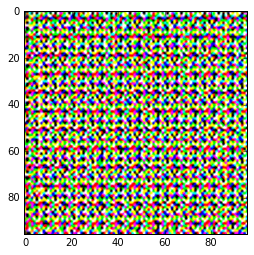

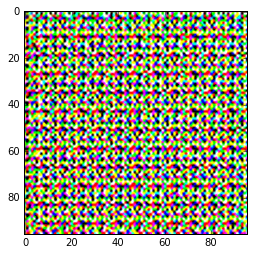

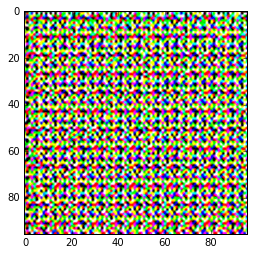

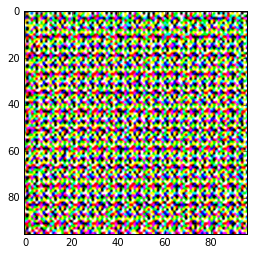

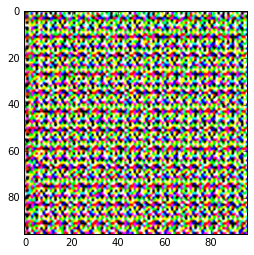

(1, 27.221634, 5.6002808)
(2, 28.581882, 3.9648678)
(3, 28.987225, 3.6030173)
(4, 27.520817, 4.5539966)
(5, 25.804977, 5.3380966)
(6, 24.594313, 5.6308823)
(7, 23.514851, 7.3118281)
(8, 22.935165, 6.9499846)


In [ ]:
sess = tf.Session()
sess.run(tf.initialize_all_variables(), feed_dict={train_phase: True})
saver = tf.train.Saver()

step = 0
for i in range(40):
    for j in range(num_batch):
        batch_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, z_dim]).astype(np.float32)

        d_loss, _ = sess.run([D_loss, train_op_D], feed_dict={noise: batch_noise, X: get_next_batch(j), train_phase: True})
        g_loss, _ = sess.run([G_loss, train_op_G], feed_dict={noise: batch_noise, X: get_next_batch(j), train_phase: True})

        print(step, d_loss, g_loss)

        # 保存模型并生成图像
        if step % 100 == 0:
            saver.save(sess, "gan_faces.model", global_step=step)

            test_noise = np.random.uniform(-1.0, 1.0, size=(5, z_dim)).astype(np.float32)
            images = sess.run(fake_image, feed_dict={noise: test_noise, train_phase: False})

            for k in range(5):
                image = images[k, :, :, :]
                image += 1
                image *= 127.5
                image = np.clip(image, 0, 255).astype(np.uint8)
                image = np.reshape(image, (IMAGE_SIZE, IMAGE_SIZE, -1))
                misc.imsave('fake_image' + str(step) + str(k) + '.jpg', image)
                plot_image(image)

        step += 1